### Set up the parameters in cell below, then run the entire notebook to get a quick summary of the results from the simulation, and a framework for further analysis

In [13]:
# imports
import math
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
# Parameters
run_bundle_name = "BIG_CA_30" # REPLACE WITH YOUR DESIRED SIMULATION RUN

# Other variables
male_colour = "#09bfc4"
female_colour = "#f86d63"

#### outcome_matrix_alive.csv

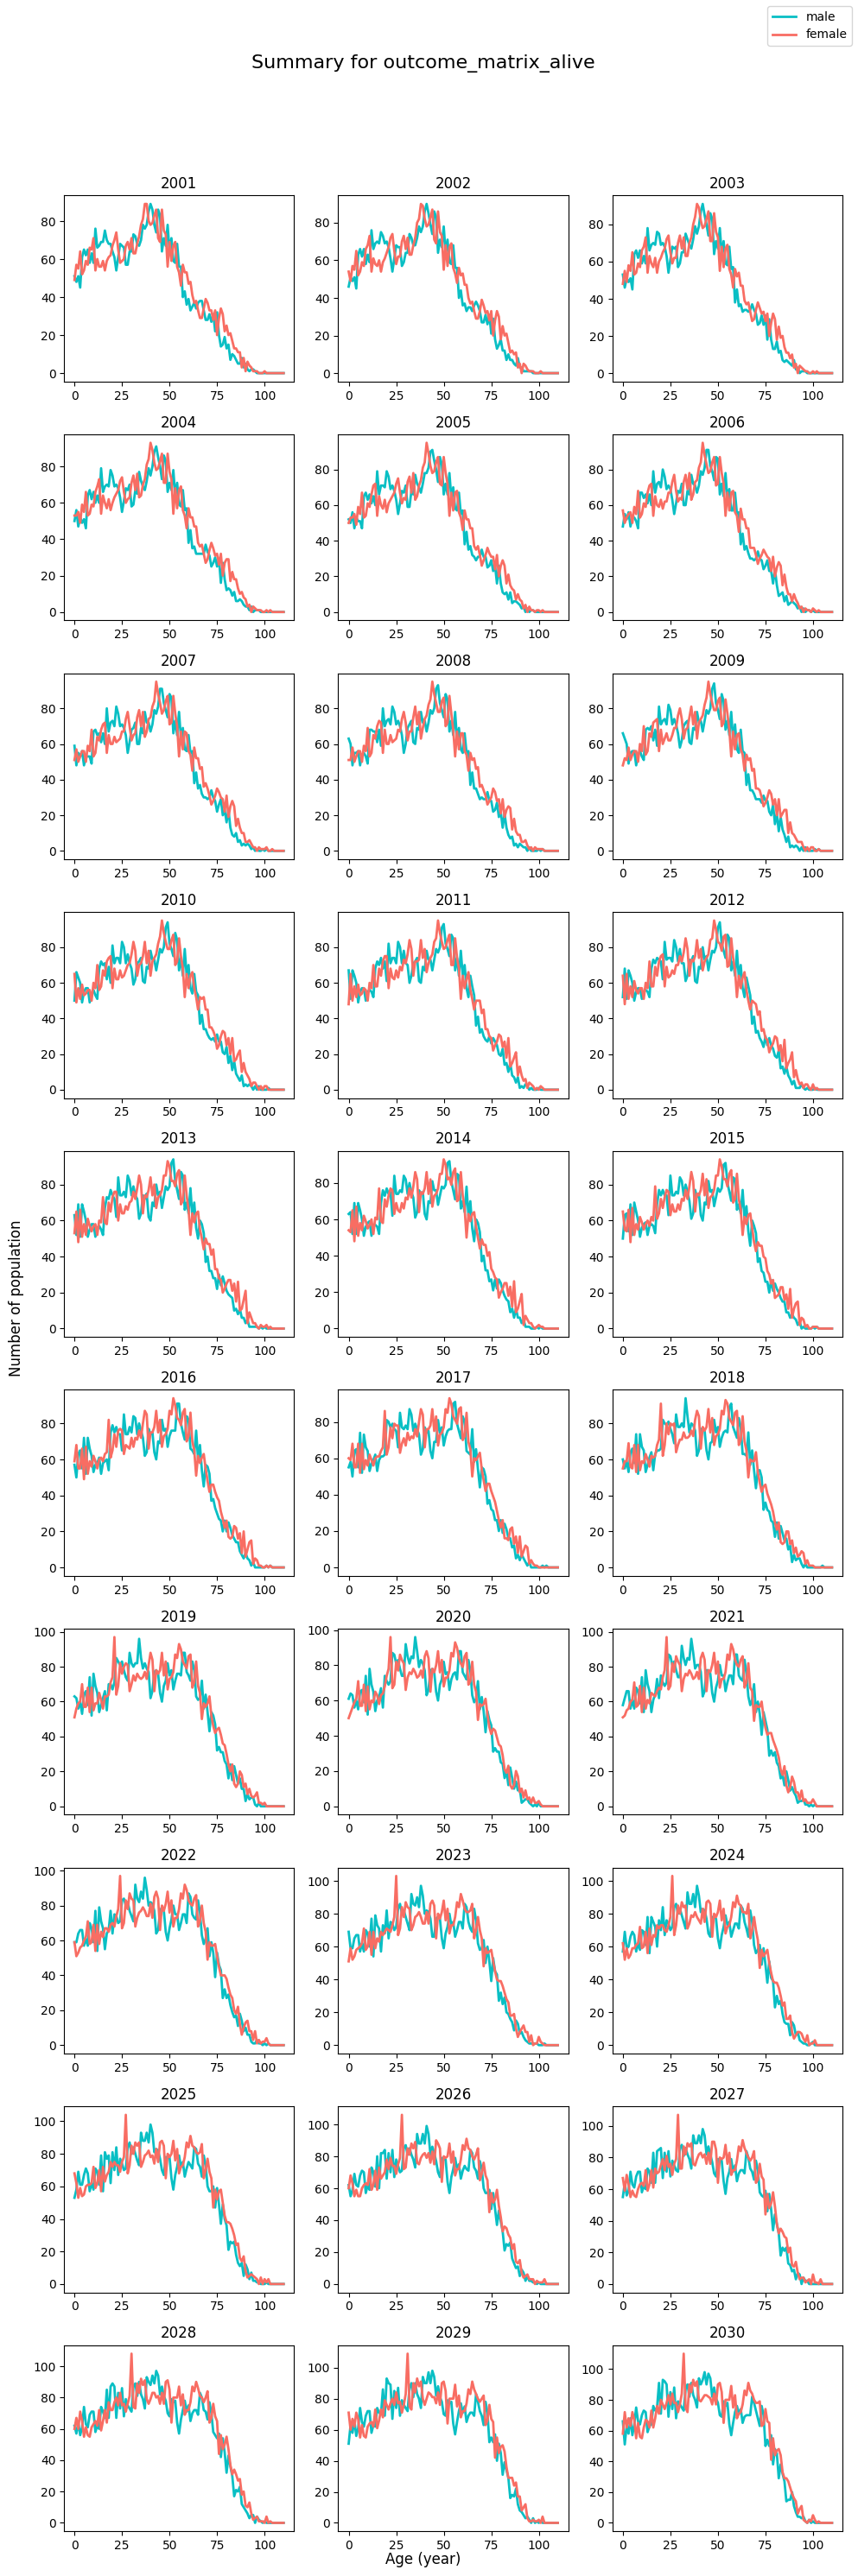

In [26]:
# Plots for outcome_matrix_alive.csv

# Read in population data from simulation
om_alive : pd.DataFrame = pd.read_csv(f"output/{run_bundle_name}/outcome_matrix_alive.csv")

# Figure Parameters
years = om_alive["year"].unique()
num_cols = 3
# Dynamically calculate number of rows based on number of years and number of columns
num_rows = math.ceil(len(years) / num_cols)

# Set up figure and axes
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 3 * num_rows))

for i, year in enumerate(years):
    # Index axis to be in 2D grid of size (num_rows x num_cols) using i
    ax : plt.Axes = axs[i // num_cols][i % num_cols]
    
    # Filter simulation data by current year
    om_alive_modified = om_alive[om_alive["year"] == year]
    
    # Filter by males and females
    om_alive_M = om_alive_modified[om_alive_modified["sex"] == "M"]
    om_alive_F = om_alive_modified[om_alive_modified["sex"] == "F"]
    
    ax.plot(om_alive_M["age"],
            om_alive_M["n_alive"],
            color=male_colour,
            linewidth=2)
    
    ax.plot(om_alive_F["age"],
            om_alive_F["n_alive"],
            color=female_colour,
            linewidth=2)

    # Set axis labels
    ax.set_title(f"{year}", fontsize=12)

fig.supxlabel("Age (year)")
fig.supylabel("Number of population")
fig.suptitle("Summary for outcome_matrix_alive", fontsize=16)
fig.legend(["male", "female"])
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()